Importación de paquetes

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [112]:
# importar archivos
crossBattlelog = pd.read_parquet('datasets/teams/battlelog_teams.parquet')
crossBattlelog.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 757358 entries, 0 to 757357
Data columns (total 44 columns):
 #   Column                                 Non-Null Count   Dtype         
---  ------                                 --------------   -----         
 0   battleTime                             757358 non-null  datetime64[ns]
 1   playertag                              757358 non-null  object        
 2   event_mode                             757358 non-null  category      
 3   event_map                              757358 non-null  category      
 4   battle_type                            757358 non-null  category      
 5   battle_result                          757358 non-null  category      
 6   battle_duration                        757358 non-null  Int16         
 7   battle_trophyChange                    573018 non-null  Int8          
 8   battle_team1_player1_tag               757358 non-null  object        
 9   battle_team1_player1_name              757356 no

In [113]:
# leer brawler stats
brawlers = pd.read_parquet('datasets/brawlers/brawlers_stats.parquet')
brawlers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 17 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              64 non-null     int64  
 1   name            64 non-null     object 
 2   starPowers.0    64 non-null     object 
 3   starPowers.1    64 non-null     object 
 4   gadgets.0       64 non-null     object 
 5   gadgets.1       64 non-null     object 
 6   Brawler         64 non-null     object 
 7   Health          64 non-null     float64
 8   Rarity          64 non-null     object 
 9   Class           64 non-null     object 
 10  Movement_Speed  64 non-null     object 
 11  Range           63 non-null     object 
 12  Reload          63 non-null     object 
 13  Speed_Num       64 non-null     int64  
 14  Range_Num       64 non-null     float64
 15  Reload_Num      63 non-null     float64
 16  Role            64 non-null     object 
dtypes: float64(3), int64(2), object(12)
m

In [114]:
# leer datos de mapa
bushList = pd.read_csv('datasets/maps/bushList.csv', index_col=0)
bushList.columns = bushList.columns.str.replace('.', '_', regex=True)
waterList = pd.read_csv('datasets/maps/waterList.csv', index_col=0)
waterList.columns = waterList.columns.str.replace('.', '_', regex=True)
barrierList = pd.read_csv('datasets/maps/barrierList.csv', index_col=0)
barrierList.columns = barrierList.columns.str.replace('.', '_', regex=True)

In [115]:
# leer brawler winrate y userate
brawler_wr_ur = pd.read_parquet('datasets/teams/brawler_winrate_userate.parquet')
brawler_wr_ur_overall = pd.read_parquet('datasets/teams/brawler_winrate_userate_overall.parquet')

In [116]:
# leer player stats
players = pd.read_parquet('datasets/players/players.parquet')

In [121]:
# función para identificar a que team pertenece el player
def team_assignment(row):
    if any(row['playertag'] == tag for tag in [row.battle_team1_player1_tag, row.battle_team1_player2_tag, row.battle_team1_player3_tag]):
        return 1
    elif any(row['playertag'] == tag for tag in [row.battle_team2_player1_tag, row.battle_team2_player2_tag, row.battle_team2_player3_tag]):
        return 2
    else:
        return "error in team assignation for id " + str(row.name)

crossBattlelog['player_team'] = crossBattlelog.apply(team_assignment, axis=1)

crossBattlelog['player_team'].value_counts()

2    380778
1    371537
Name: player_team, dtype: int64

In [122]:
# eliminar draws, no aportan al modelo
crossBattlelog = crossBattlelog[crossBattlelog['battle_result'] != 'draw'].reset_index(drop=True)

In [123]:
# crear columna winner_team
def winner_assignment(row):
	if row.battle_result == 'draw':
		return 'draw'
	elif (row.player_team == 1 and row.battle_result == 'victory') or (row.player_team == 2 and row.battle_result == 'defeat'):
		return 1
	elif (row.player_team == 2 and row.battle_result == 'victory') or (row.player_team == 1 and row.battle_result == 'defeat'):
		return 2
	else:
		return "error in winner assignation for id " + str(row.name)

crossBattlelog['winner_team'] = crossBattlelog.apply(winner_assignment, axis=1)

crossBattlelog['winner_team'].value_counts()

1    376757
2    375558
Name: winner_team, dtype: int64

In [124]:
crossBattlelog

,battleTime,playertag,event_mode,event_map,battle_type,battle_result,battle_duration,battle_trophyChange,battle_team1_player1_tag,battle_team1_player1_name,...,battle_team2_player2_brawler_power,battle_team2_player2_brawler_trophies,battle_team2_player3_tag,battle_team2_player3_name,battle_team2_player3_brawler_id,battle_team2_player3_brawler_name,battle_team2_player3_brawler_power,battle_team2_player3_brawler_trophies,player_team,winner_team
0,2023-02-11,#VGPLRCVQ,gemGrab,Deep Diner,ranked,victory,103,4,#YLCCPLJRY,"""MÀHMÕŪĐ""",...,11,1148,#P9Y9PGVUU,乂𝖘𝖔𝖑𝖑𝖆𝖗🛸,16000026,BIBI,11,892,2,2
1,2023-02-11,#VGPLRCVQ,gemGrab,Deep Diner,ranked,victory,105,4,#2YLCUUJ9,Lakozar ❤️‍🔥,...,11,757,#GGCYYYCJ,PB|liris,16000008,NITA,11,807,1,1
2,2023-02-11,#VGPLRCVQ,gemGrab,Deep Diner,ranked,victory,89,4,#89CU2GC0R,beflap,...,11,1140,#P9Y9PGVUU,乂𝖘𝖔𝖑𝖑𝖆𝖗🛸,16000026,BIBI,11,878,2,2
3,2023-02-11,#VGPLRCVQ,gemGrab,Deep Diner,ranked,victory,82,4,#2CGLQRPLJ,WhyPrince 👹,...,11,871,#VGPLRCVQ,Buzkoa,16000043,EDGAR,11,1136,2,2
4,2023-02-11,#VGPLRCVQ,gemGrab,Deep Diner,ranked,victory,82,4,#2YLCUUJ9,Lakozar ❤️‍🔥,...,11,771,#PCP2UQV8,lawl,16000010,EL PRIMO,9,801,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
752310,2023-01-02,#2222VVG82,gemGrab,Double Swoosh,ranked,defeat,90,-12,#22VGCGUU0,PяєттуBσу🌻,...,10,1171,#22V9R0P02,𝙽𝙸𝙺𝙾♡~,16000063,CHESTER,11,1083,2,1
752311,2023-01-01,#CPL9PLC8,hotZone,Quarter Pounder,ranked,victory,91,7,#8PL09PQ80,『𝙈𝙖𝙮𝙤🐺』,...,11,752,#CPL9PLC8,Yolo 🎈,16000064,GRAY,11,883,2,2
752312,2023-01-02,#YPGUYYLJ,gemGrab,Double Swoosh,ranked,defeat,131,-12,#9P08V9JV0,ain.Batonchik💖,...,11,882,#2GPRL99YV,AD|VenoM🐽,16000063,CHESTER,11,891,1,2
752313,2023-01-02,#220PGLU02,gemGrab,Double Swoosh,ranked,victory,119,5,#RCV88CQG,kkaj,...,11,319,#220PGLU02,家|𝑴𝒆𝒎𝒆𝒏ϟ,16000063,CHESTER,11,1058,2,2


In [ ]:
# # crear columna winner
# def subset_winner(df, team):

# 	df['winner'] = 'no'

# 	for i, winner_team in enumerate(df['winner_team']):
# 		if winner_team == team:
# 			df.loc[i, 'winner'] = 'yes'

# 	df = df.rename(columns={
# 		'battle_' + team + '_player1_tag': 'battle_player1_tag',
# 		'battle_' + team + '_player1_brawler_name': 'battle_player1_brawler_name',
# 		'battle_' + team + '_player1_brawler_power': 'battle_player1_brawler_power',
# 		'battle_' + team + '_player1_brawler_trophies': 'battle_player1_brawler_trophies',
# 		'battle_' + team + '_player2_tag': 'battle_player2_tag',
# 		'battle_' + team + '_player2_brawler_name': 'battle_player2_brawler_name',
# 		'battle_' + team + '_player2_brawler_power': 'battle_player2_brawler_power',
# 		'battle_' + team + '_player2_brawler_trophies': 'battle_player2_brawler_trophies',
# 		'battle_' + team + '_player3_tag': 'battle_player3_tag',
# 		'battle_' + team + '_player3_brawler_name': 'battle_player3_brawler_name',
# 		'battle_' + team + '_player3_brawler_power': 'battle_player3_brawler_power',
# 		'battle_' + team + '_player3_brawler_trophies': 'battle_player3_brawler_trophies',
# 	})

# 	df = df[[	
# 		'event_mode',
# 		'event_map',
# 		'battle_type',
# 		'battle_duration',
# 		'battle_player1_tag',
# 		'battle_player1_brawler_name',
# 		'battle_player1_brawler_power',
# 		'battle_player1_brawler_trophies',
# 		'battle_player2_tag',
# 		'battle_player2_brawler_name',
# 		'battle_player2_brawler_power',
# 		'battle_player2_brawler_trophies',
# 		'battle_player3_tag',
# 		'battle_player3_brawler_name',
# 		'battle_player3_brawler_power',
# 		'battle_player3_brawler_trophies',
# 		'winner',
# 	]]

# 	return df

# def clean_winner(team):

# 	if team == 'team1':
# 		oteam = 'team2'
# 	else:
# 		oteam = 'team1'
	
# 	subset = crossBattlelog[crossBattlelog['winner_team'] == team].reset_index(drop=True)

# 	dfwinners = subset_winner(subset, team)

# 	dfloosers = subset_winner(subset, oteam)

# 	return pd.concat([dfwinners, dfloosers], ignore_index=True)

# team1 = clean_winner('team1')
# team2 = clean_winner('team2')

# battlelogProcess = pd.concat([team1, team2], ignore_index=True)
# battlelogProcess.info()

In [241]:
# brawlers['Range'].value_counts()

# reemplazar valores de brawler range
brawlers['Range'] = brawlers['Range'].replace('close range; Normal', 'Short')
brawlers['Range'] = brawlers['Range'].replace('min range; Normal', 'Normal')
brawlers['Range'] = brawlers['Range'].replace('Clyde; Very Long', 'Very Long')

# reemplazar nan por 'Normal'
brawlers['Range'] = brawlers['Range'].fillna('Normal')

brawlers['Range'].value_counts()


Long         28
Very Long    14
Normal       12
Short        10
Name: Range, dtype: int64

In [125]:
# merge brawler stats
batltlelog = crossBattlelog

def add_brawlers(df, prefix):
	df = pd.merge(left=df, right=brawlers[['name','Health','Rarity','Class','Movement_Speed','Range','Reload','Speed_Num','Range_Num','Reload_Num','Role']].add_prefix(prefix), on=prefix + 'name', how='left', suffixes=('','_b'))
	return df

batltlelog = add_brawlers(batltlelog, 'battle_team1_player1_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team1_player2_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team1_player3_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team2_player1_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team2_player2_brawler_')
batltlelog = add_brawlers(batltlelog, 'battle_team2_player3_brawler_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 752315 entries, 0 to 752314
Columns: 106 entries, battleTime to battle_team2_player3_brawler_Role
dtypes: Int16(7), Int32(6), Int8(7), category(4), datetime64[ns](1), float64(18), int64(8), object(55)
memory usage: 525.9+ MB


In [126]:
# merge player stats
def merge_playerstats(df, prefix):
	df = pd.merge(left=df, right=players.add_prefix(prefix), on=prefix + 'tag', how='inner')
	return df

batltlelog = merge_playerstats(batltlelog, 'battle_team1_player1_')
batltlelog = merge_playerstats(batltlelog, 'battle_team1_player2_')
batltlelog = merge_playerstats(batltlelog, 'battle_team1_player3_')
batltlelog = merge_playerstats(batltlelog, 'battle_team2_player1_')
batltlelog = merge_playerstats(batltlelog, 'battle_team2_player2_')
batltlelog = merge_playerstats(batltlelog, 'battle_team2_player3_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747957 entries, 0 to 747956
Columns: 136 entries, battleTime to battle_team2_player3_datetime
dtypes: Int16(7), Int32(6), Int8(7), category(4), datetime64[ns](7), float64(18), int64(32), object(55)
memory usage: 694.0+ MB


In [127]:
# merge map data
batltlelog = batltlelog.merge(barrierList, how='inner', on='event_map')
batltlelog = batltlelog.merge(bushList, how='inner', on='event_map')
batltlelog = batltlelog.merge(waterList, how='left', on='event_map')
batltlelog['waterProp'] = batltlelog['waterProp'].fillna(0)
batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747957 entries, 0 to 747956
Columns: 141 entries, battleTime to waterProp
dtypes: Int16(7), Int32(6), Int8(7), category(3), datetime64[ns](7), float64(19), int64(36), object(56)
memory usage: 727.6+ MB


In [128]:
# merge winrate y userate
def add_wr_ur(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur[['brawlername', 'event_mode', 'event_map', 'winrate']].add_prefix(prefix)
		,left_on=[prefix + 'name', 'event_mode', 'event_map']
		,right_on=[prefix + 'brawlername', prefix + 'event_mode', prefix + 'event_map']
		,how='left'
		,suffixes=('','_w'))
	return df

batltlelog = add_wr_ur(batltlelog, 'battle_team1_player1_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team1_player2_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team1_player3_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team2_player1_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team2_player2_brawler_')
batltlelog = add_wr_ur(batltlelog, 'battle_team2_player3_brawler_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747957 entries, 0 to 747956
Columns: 165 entries, battleTime to battle_team2_player3_brawler_winrate
dtypes: Int16(7), Int32(6), Int8(7), category(21), datetime64[ns](7), float64(25), int64(36), object(56)
memory usage: 774.7+ MB


In [129]:
# merge winrate y userate overall
def add_wr_ur_oa(df, prefix):
	df = pd.merge(
		left=df
		,right=brawler_wr_ur_overall[['brawlername', 'winrate']].add_prefix(prefix)
		,left_on=[prefix + 'name']
		,right_on=[prefix + 'brawlername']
		,how='left'
		,suffixes=('','_overall'))
	return df

batltlelog = add_wr_ur_oa(batltlelog, 'battle_team1_player1_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team1_player2_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team1_player3_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team2_player1_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team2_player2_brawler_')
batltlelog = add_wr_ur_oa(batltlelog, 'battle_team2_player3_brawler_')

batltlelog.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 747957 entries, 0 to 747956
Columns: 183 entries, battleTime to battle_team2_player3_brawler_userate
dtypes: Int16(7), Int32(6), Int8(7), category(27), datetime64[ns](7), float64(37), int64(36), object(56)
memory usage: 847.4+ MB


In [130]:
plt.style.use('ggplot')

In [170]:
# crear columna avg

battlelogFinal = batltlelog

def create_avg(row, column, team):
    return (row['battle_' + team + '_player1_'+ column] + row['battle_' + team + '_player2_'+ column] + row['battle_' + team + '_player3_'+ column]) / 3

cols = ['brawler_Range_Num',
'brawler_trophies',
'brawler_Health',
'brawler_Speed_Num',
'brawler_winrate',
'brawler_winrate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

for col in cols:
    for team in ['team1', 'team2']:
        battlelogFinal['avg_' + col + '_' + team] = battlelogFinal.apply(lambda row: create_avg(row, col, team), axis=1)


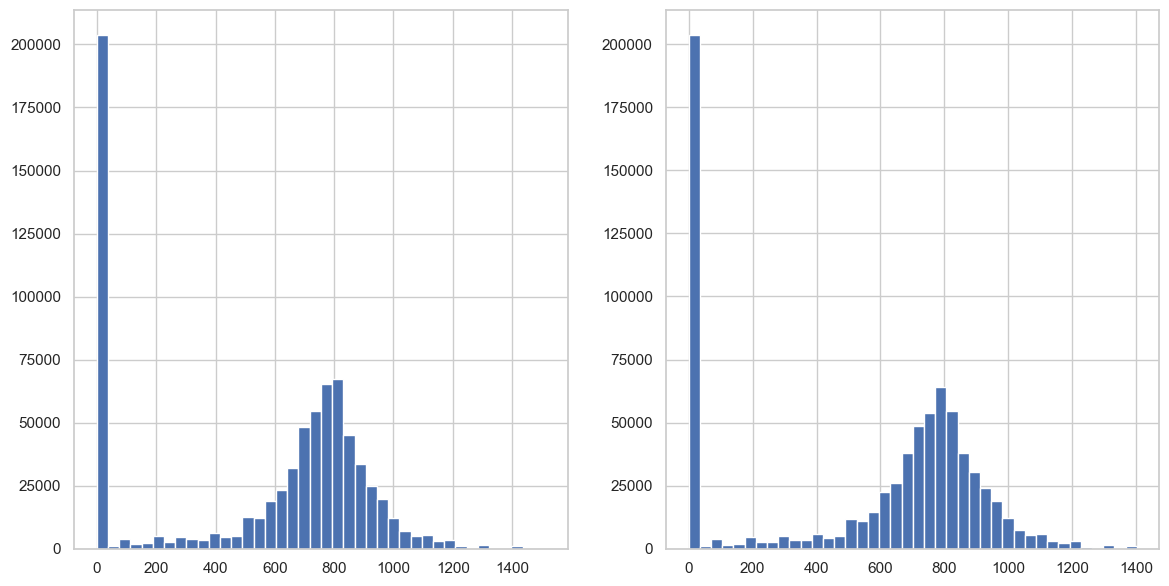

In [171]:
# plot trophies

fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].hist(x=battlelogFinal['avg_brawler_trophies_team1'], bins=40)
ax[1].hist(x=battlelogFinal['avg_brawler_trophies_team2'], bins=40)
plt.show()


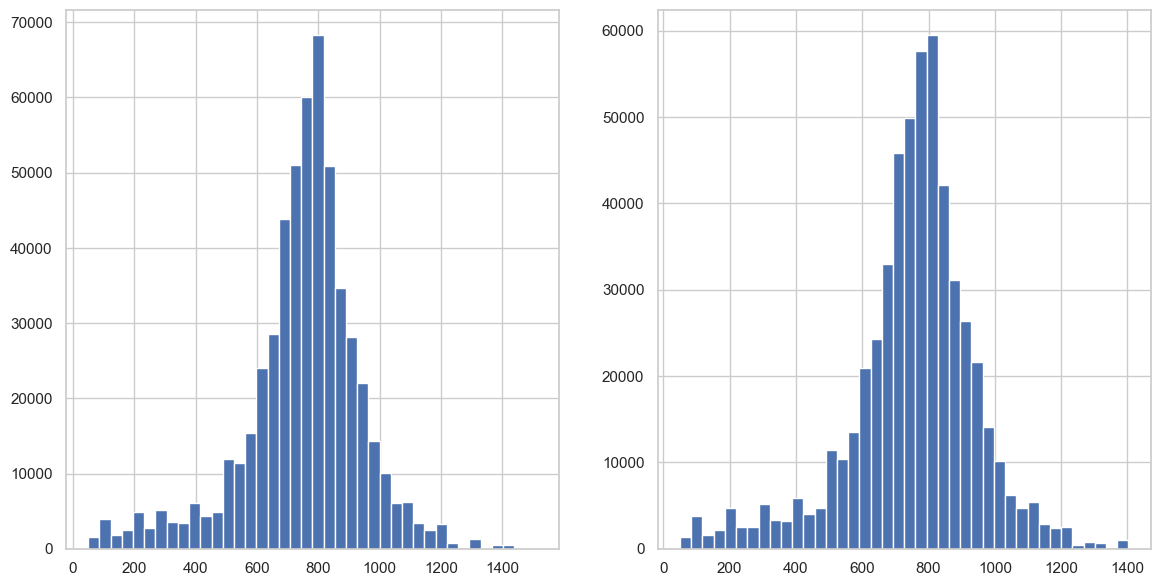

In [172]:

# subset avg trophies
battlelogFinal = battlelogFinal[(battlelogFinal['avg_brawler_trophies_team1'] > 50) & (battlelogFinal['avg_brawler_trophies_team2'] > 50)].reset_index(drop = True)

fig, ax = plt.subplots(1, 2, figsize=(14,7))
ax[0].hist(x=battlelogFinal['avg_brawler_trophies_team1'], bins=40)
ax[1].hist(x=battlelogFinal['avg_brawler_trophies_team2'], bins=40)
plt.show()

In [186]:
# order rows
def get_min_max_rest(row, column_names):
    a, b, c = row[column_names[0]], row[column_names[1]], row[column_names[2]]
    min_val = min(a, b, c)
    max_val = max(a, b, c)
    # rest_val = (a + b + c) - min_val - max_val
    # return min_val, max_val, rest_val
    return min_val, max_val

def order_rows(df, column, team):
	column_names = ['battle_' + team + '_player1_' + column, 'battle_' + team + '_player2_' + column, 'battle_' + team + '_player3_' + column]
	# min_vals, max_vals, rest_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	min_vals, max_vals = zip(*df.apply(lambda x: get_min_max_rest(x, column_names), axis=1))
	return min_vals, max_vals

cols = ['brawler_Range_Num',
'brawler_trophies',
'brawler_Health',
'brawler_Speed_Num',
'brawler_winrate',
'brawler_winrate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal['min_' + col + '_' + team], battlelogFinal['max_' + col + '_' + team] = order_rows(battlelogFinal, col, team)

In [187]:
# Transformar a log
def to_log(df, column):
	df[column] = np.log(df[column] + 1)
	return df[column]

cols = ['avg_brawler_trophies',
'min_brawler_trophies',
'max_brawler_trophies',
'avg_trophies',
'min_trophies',
'max_trophies',
'avg_highestTrophies',
'min_highestTrophies',
'max_highestTrophies',
'avg_brawler_Health',
'min_brawler_Health',
'max_brawler_Health',
'avg_brawler_Speed_Num',
'min_brawler_Speed_Num',
'max_brawler_Speed_Num',
'avg_team_victories',
'min_team_victories',
'max_team_victories',
'avg_expPoints',
'min_expPoints',
'max_expPoints',
]

cols_map = [
'barriers',
'barriers_center',
'bushes',
'bushes_center',
]

for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal[col + '_' + team] = to_log(battlelogFinal, col + '_' + team)

for col in cols_map:
	battlelogFinal[col] = to_log(battlelogFinal, col)

In [188]:
sns.set_palette("Blues")
sns.set(style="whitegrid")

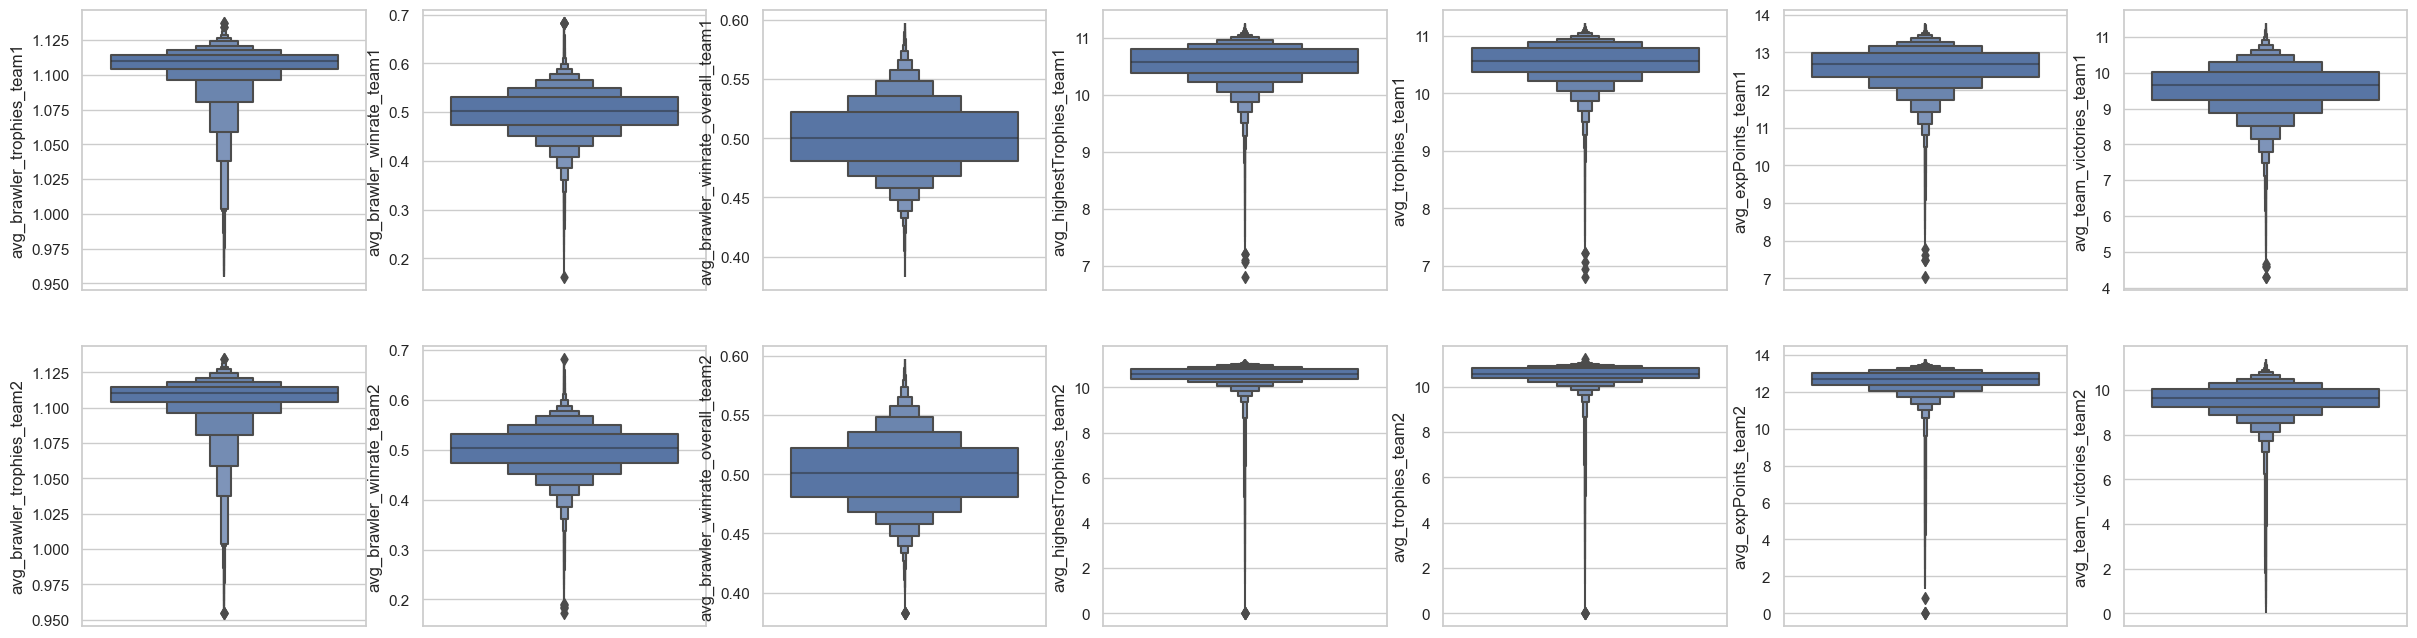

In [189]:
# graficar
cols = ['brawler_trophies',
'brawler_winrate',
'brawler_winrate_overall',
'highestTrophies',
'trophies',
'expPoints',
'team_victories']

fig, ax = plt.subplots(2, len(cols), figsize=(30, 12))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['avg_' + col + '_' + team], ax=ax[j, i])

plt.show()

In [190]:

def eliminar_outliers(df, columna):
	q1 = df[columna].quantile(0.25)
	q3 = df[columna].quantile(0.75)
	iqr = q3-q1 # Rango intercuartílico
	umbral_inferior  = q1-1.5*iqr # Umbral inferior
	umbral_superior = q3+1.5*iqr # Umbral superior
	df_sin_outliers = df.loc[(df[columna] > umbral_inferior) & (df[columna] < umbral_superior)]
	print('eliminados ' + str(len(df) - len(df_sin_outliers)) + ' outliers de ' + columna)
	return df_sin_outliers

for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal = eliminar_outliers(battlelogFinal, 'avg_' + col + '_' + team)
		
print(battlelogFinal.shape)

eliminados 45866 outliers de avg_brawler_trophies_team1
eliminados 15662 outliers de avg_brawler_trophies_team2
eliminados 9249 outliers de avg_brawler_winrate_team1
eliminados 8614 outliers de avg_brawler_winrate_team2
eliminados 2504 outliers de avg_brawler_winrate_overall_team1
eliminados 2453 outliers de avg_brawler_winrate_overall_team2
eliminados 6853 outliers de avg_highestTrophies_team1
eliminados 6730 outliers de avg_highestTrophies_team2
eliminados 427 outliers de avg_trophies_team1
eliminados 439 outliers de avg_trophies_team2
eliminados 5396 outliers de avg_expPoints_team1
eliminados 5122 outliers de avg_expPoints_team2
eliminados 1962 outliers de avg_team_victories_team1
eliminados 1739 outliers de avg_team_victories_team2
(431055, 263)


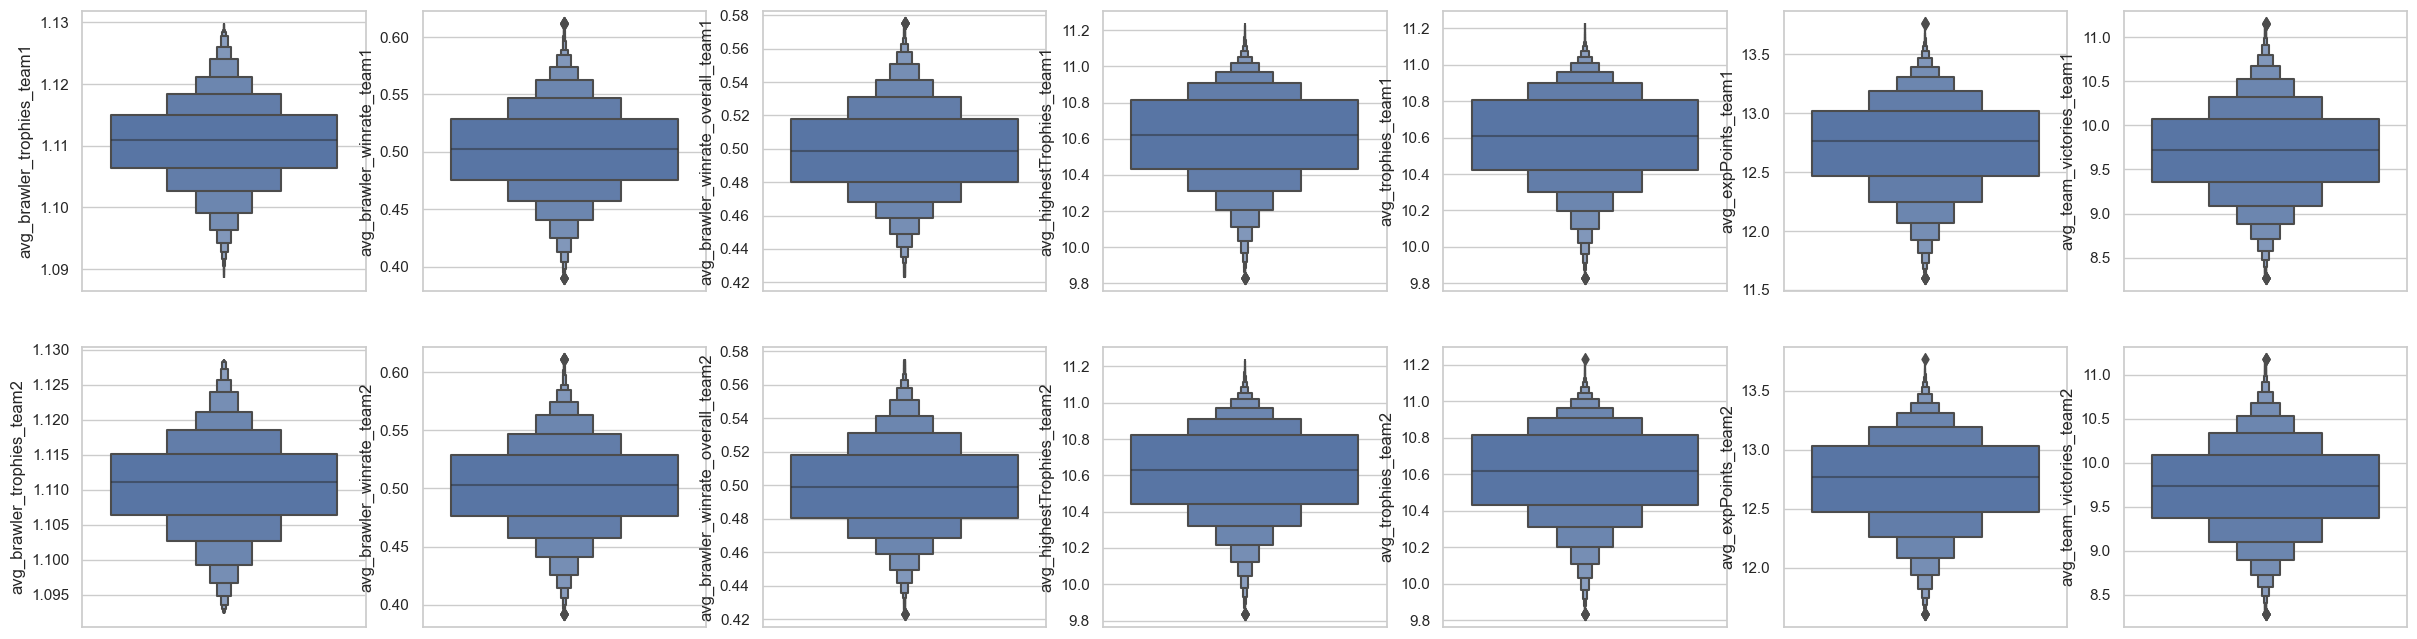

In [191]:
# graficar resultado
fig, ax = plt.subplots(2, len(cols), figsize=(30, 12))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['avg_' + col + '_' + team], ax=ax[j, i])

plt.show()

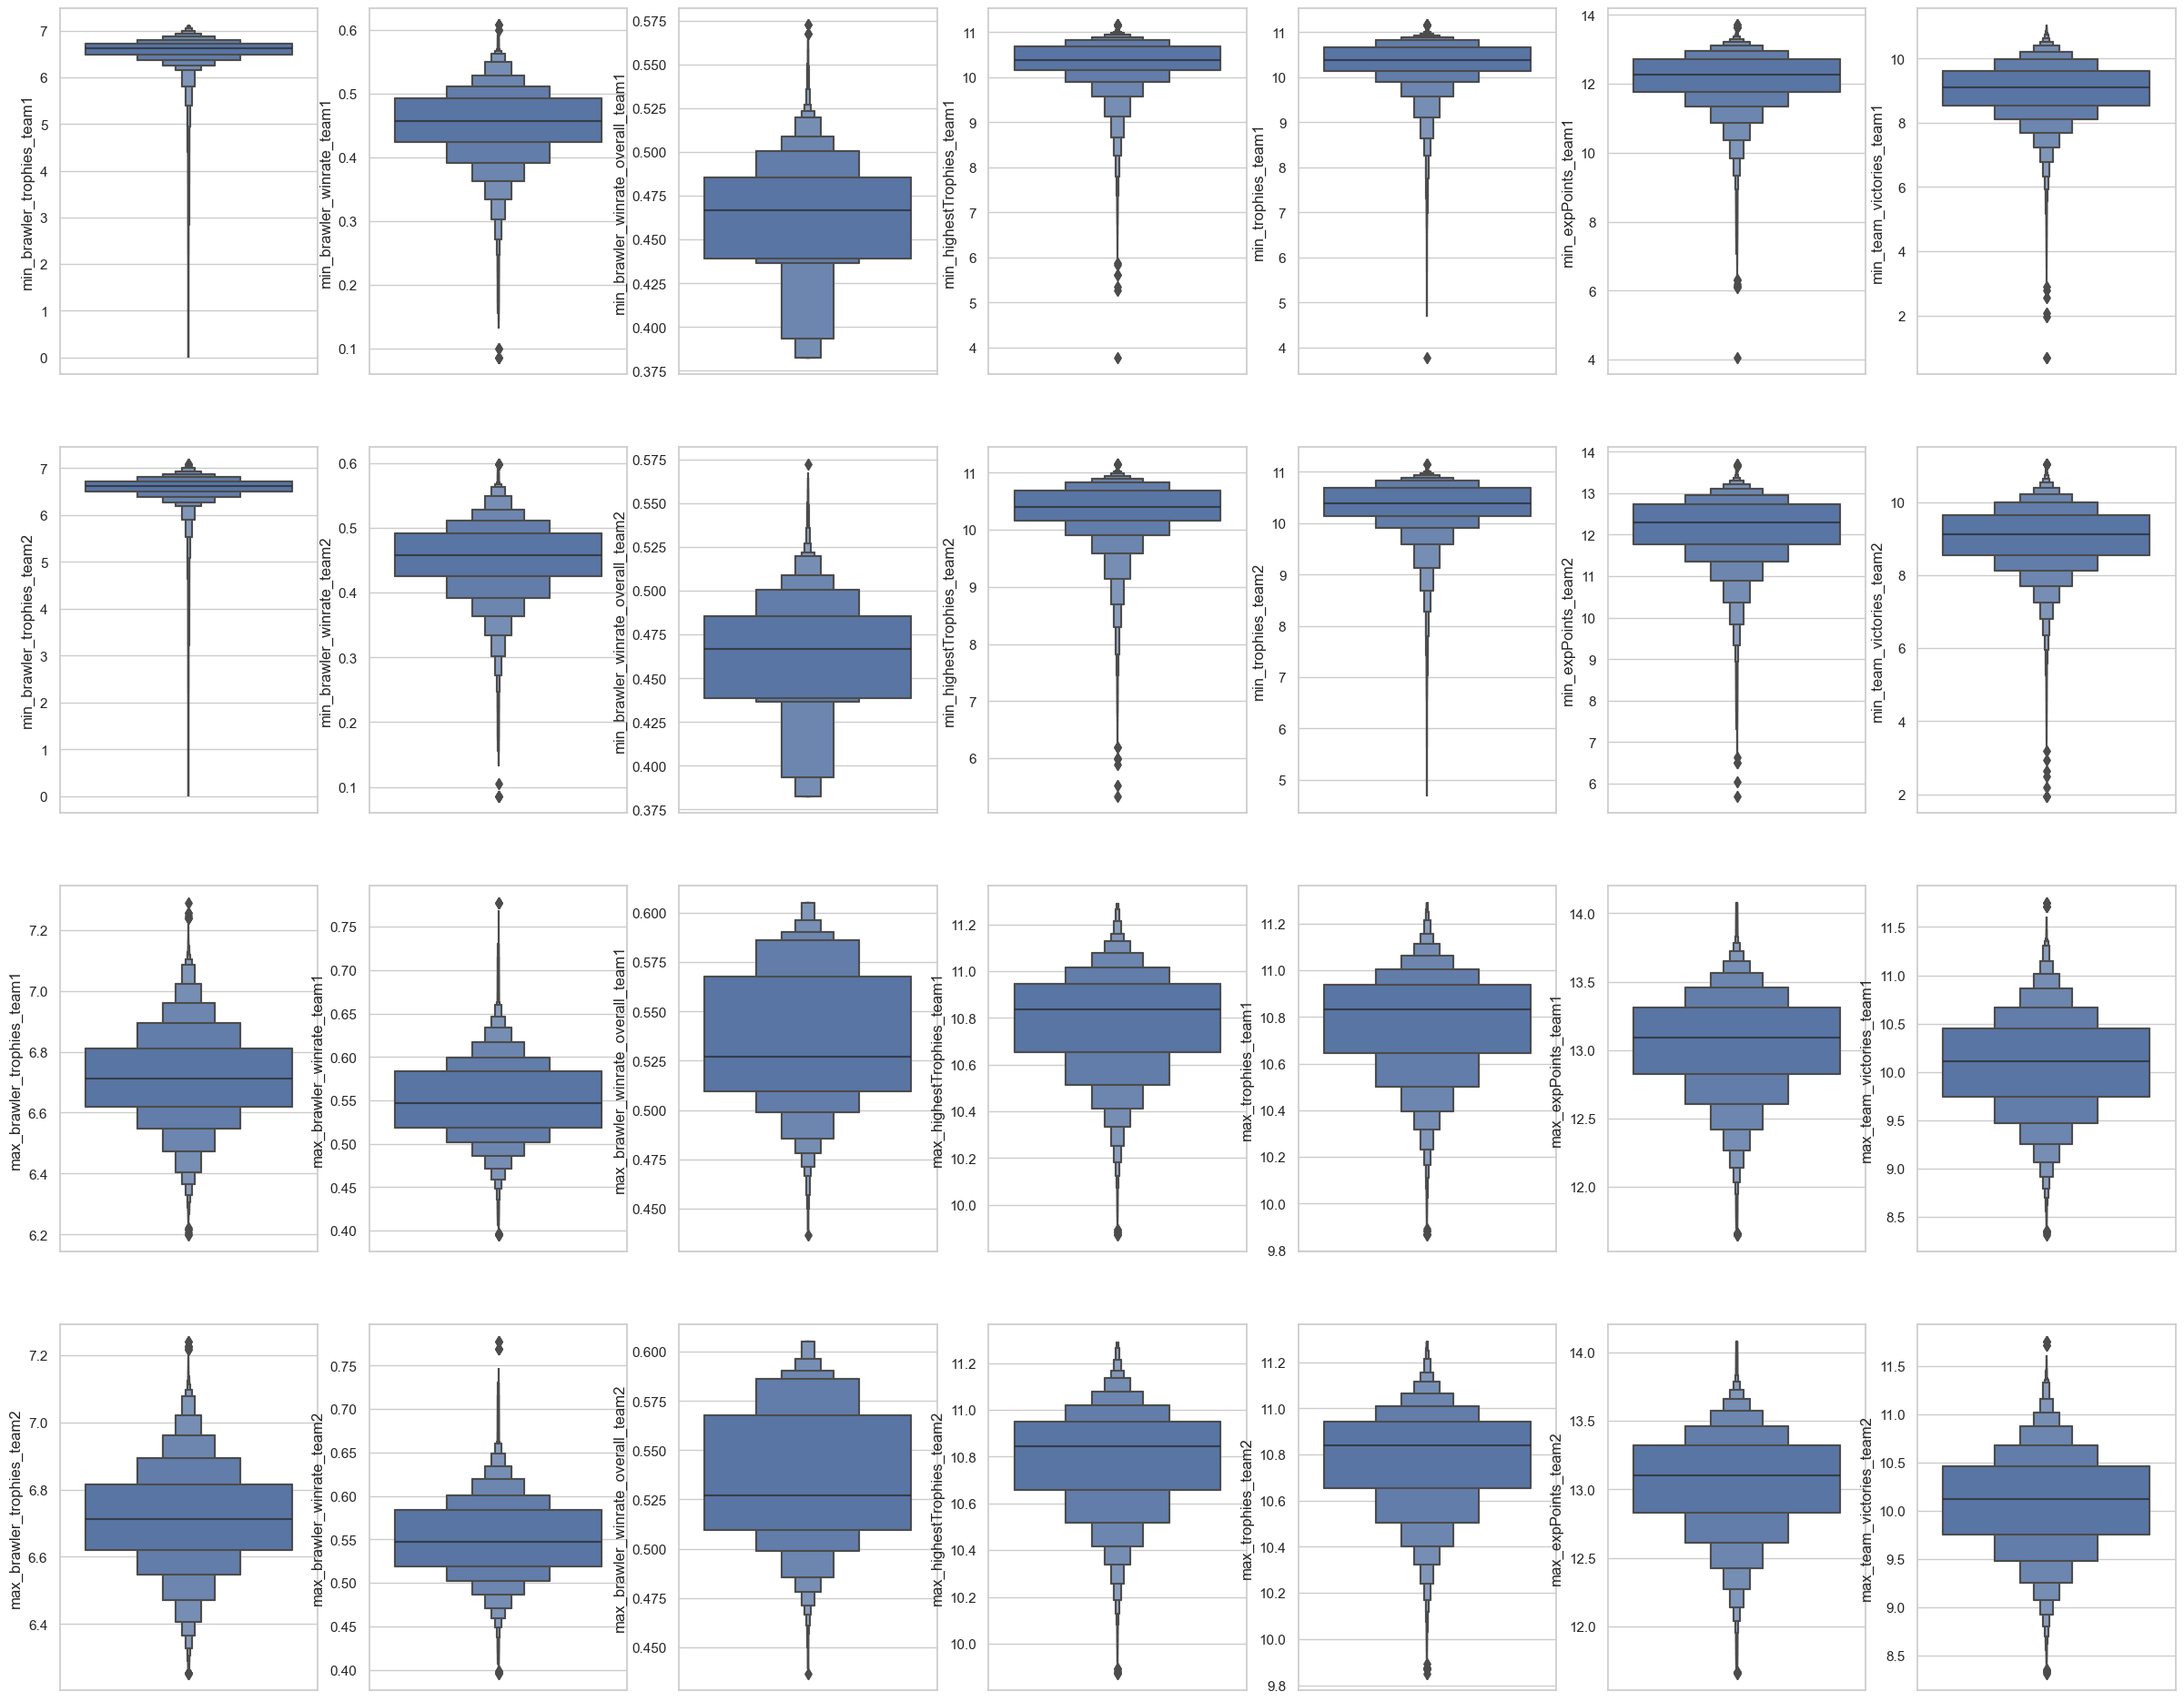

In [195]:
# graficar
fig, ax = plt.subplots(4, len(cols), figsize=(30, 24))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])

plt.show()

In [196]:
for col in cols:
	for team in ['team1', 'team2']:
		battlelogFinal = eliminar_outliers(battlelogFinal, 'min_' + col + '_' + team)
		battlelogFinal = eliminar_outliers(battlelogFinal, 'max_' + col + '_' + team)

print(battlelogFinal.shape)

eliminados 16666 outliers de min_brawler_trophies_team1
eliminados 7703 outliers de max_brawler_trophies_team1
eliminados 12509 outliers de min_brawler_trophies_team2
eliminados 4095 outliers de max_brawler_trophies_team2
eliminados 10851 outliers de min_brawler_winrate_team1
eliminados 1139 outliers de max_brawler_winrate_team1
eliminados 9719 outliers de min_brawler_winrate_team2
eliminados 922 outliers de max_brawler_winrate_team2
eliminados 272 outliers de min_brawler_winrate_overall_team1
eliminados 0 outliers de max_brawler_winrate_overall_team1
eliminados 251 outliers de min_brawler_winrate_overall_team2
eliminados 0 outliers de max_brawler_winrate_overall_team2
eliminados 14930 outliers de min_highestTrophies_team1
eliminados 4680 outliers de max_highestTrophies_team1
eliminados 14036 outliers de min_highestTrophies_team2
eliminados 4363 outliers de max_highestTrophies_team2
eliminados 2092 outliers de min_trophies_team1
eliminados 1046 outliers de max_trophies_team1
eliminados

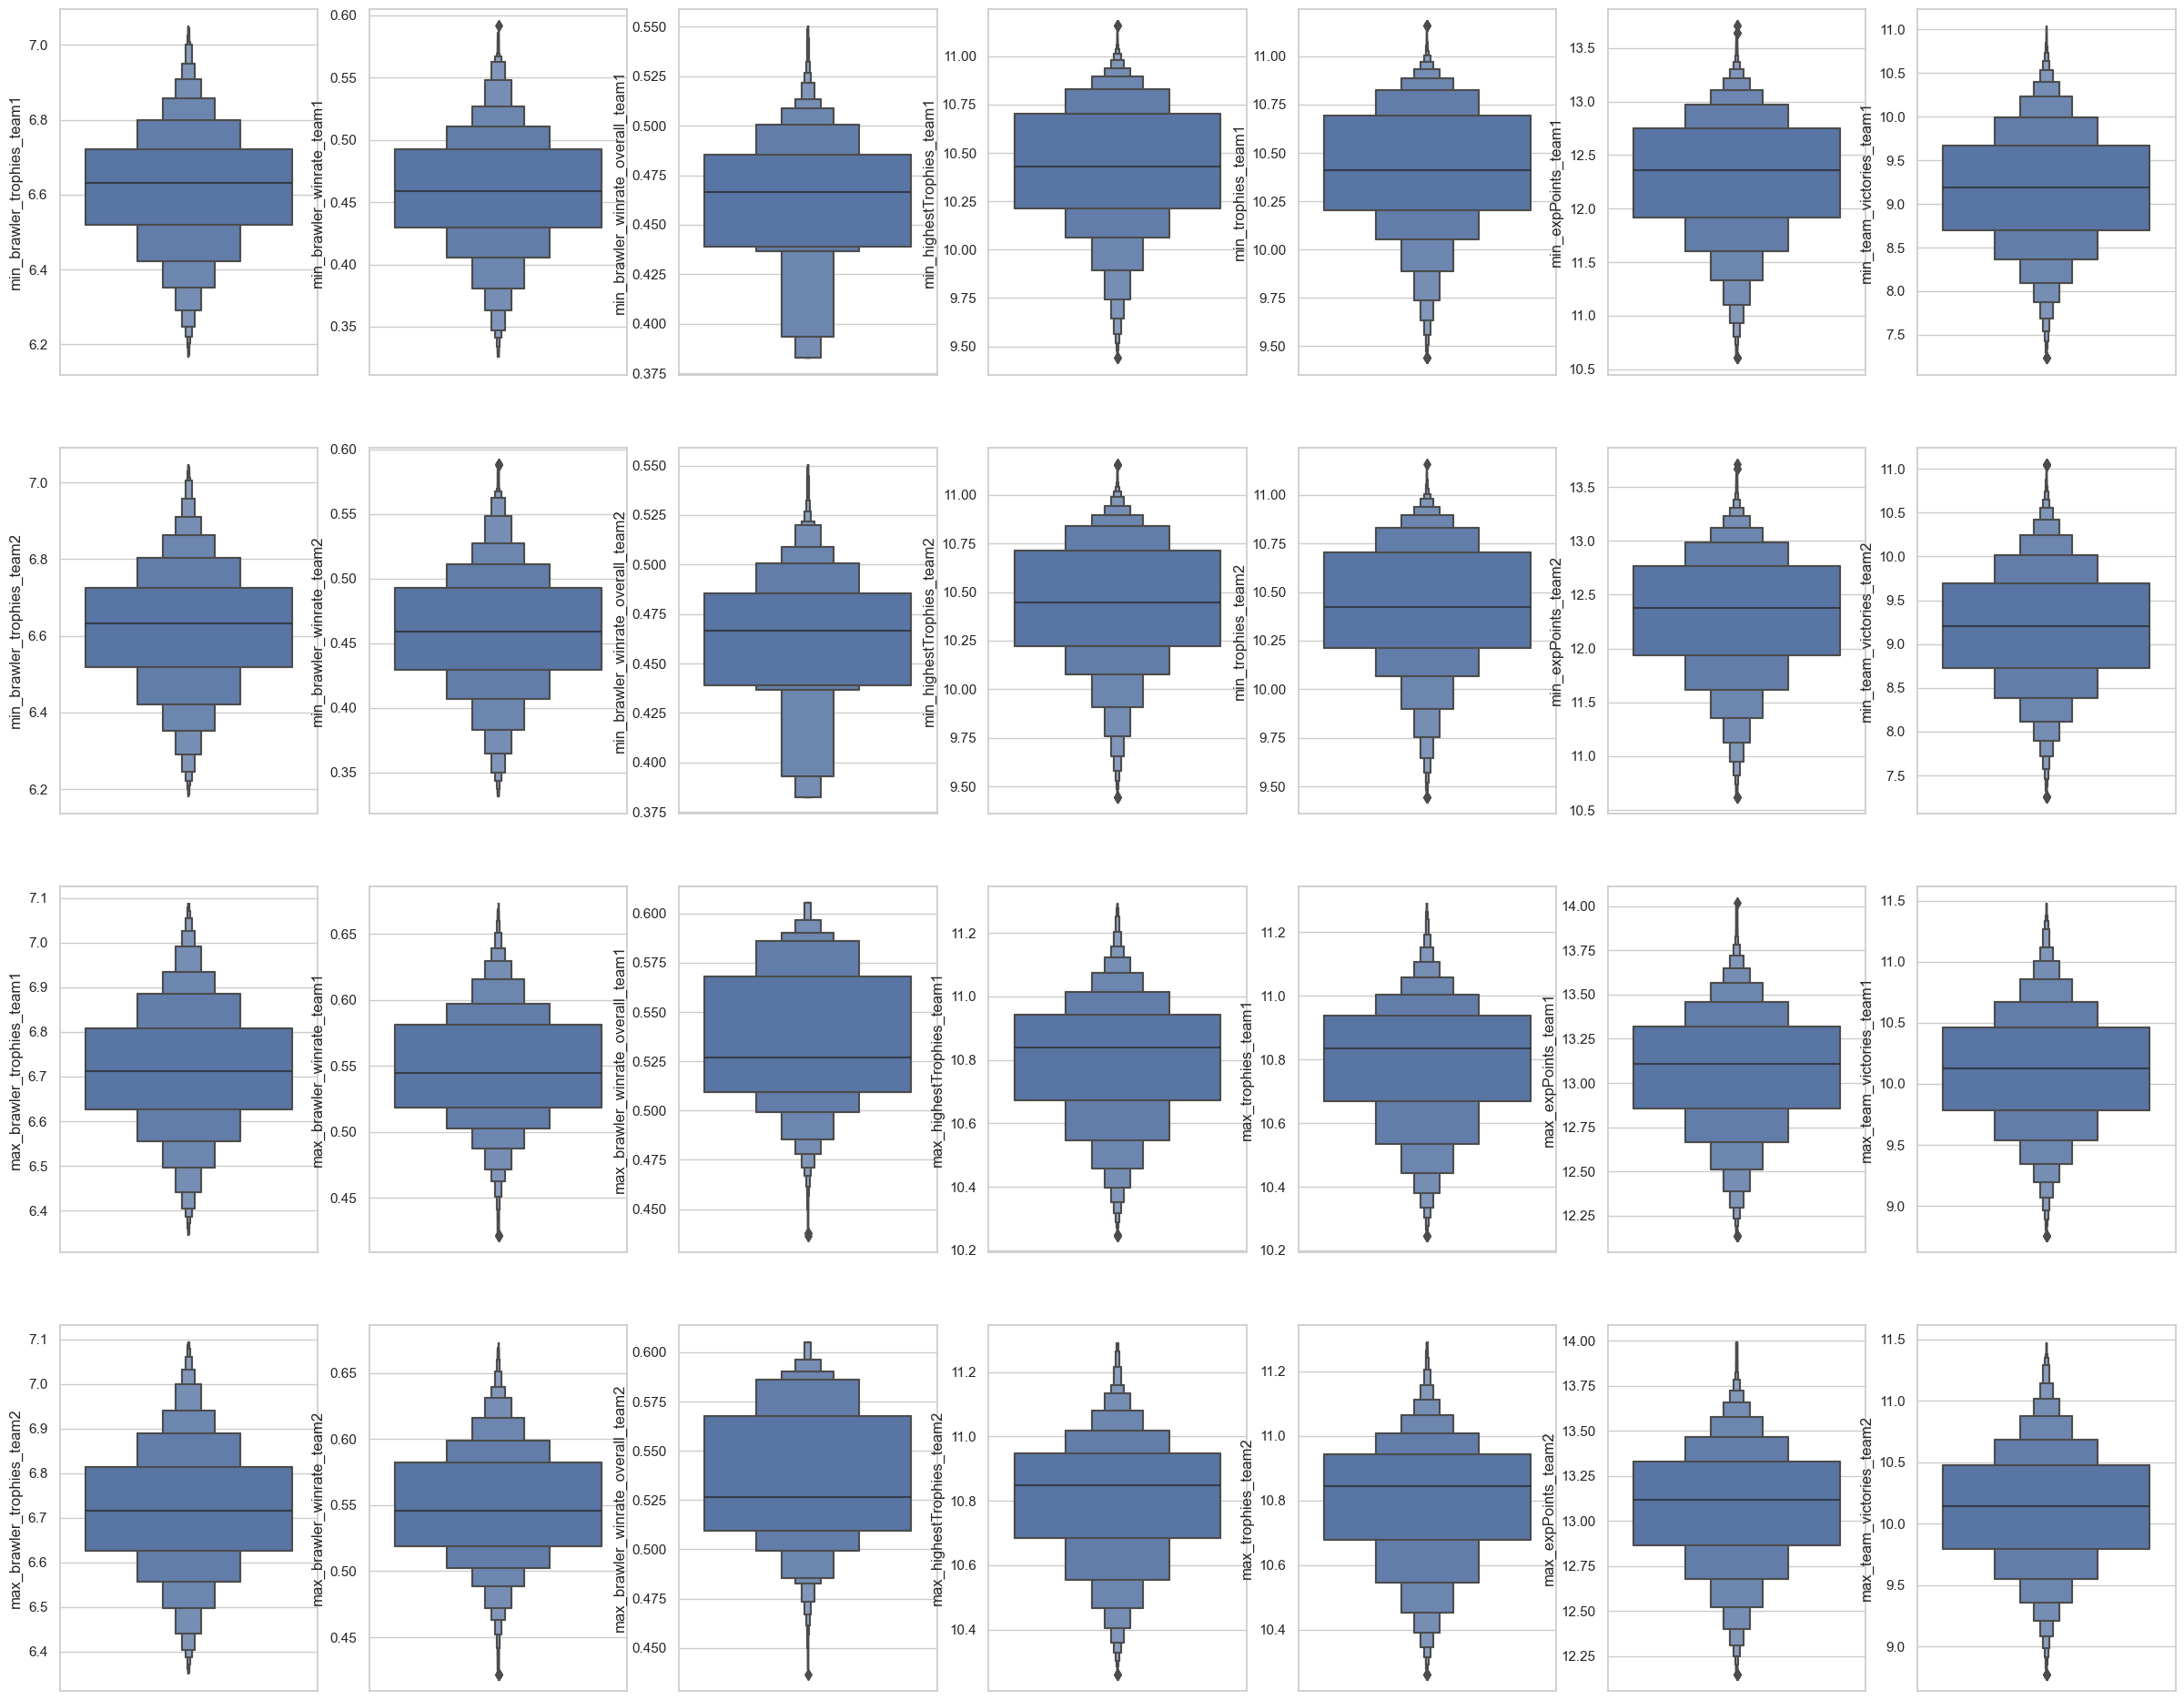

In [197]:
# graficar
fig, ax = plt.subplots(4, len(cols), figsize=(30, 24))
for i, col in enumerate(cols):
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
        sns.boxenplot(y=battlelogFinal['min_' + col + '_' + team], ax=ax[j, i])
    for j, team in enumerate(['team1', 'team2']):
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])
        sns.boxenplot(y=battlelogFinal['max_' + col + '_' + team], ax=ax[j+2, i])

plt.show()

In [198]:
# power column merge
for team in ['team1', 'team2']:
    battlelogFinal['battle_power_' + team] = battlelogFinal['battle_' + team + '_player1_brawler_power'] + battlelogFinal['battle_' + team + '_player2_brawler_power'] + battlelogFinal['battle_' + team + '_player3_brawler_power']

In [213]:
# agregar diferencia de columnas

cols = [
    'avg_brawler_Range_Num',
	'avg_brawler_trophies',
	'avg_brawler_Health',
	'avg_brawler_Speed_Num',
	'avg_brawler_winrate',
	'avg_brawler_winrate_overall',
	'avg_highestTrophies',
	'avg_trophies',
	'avg_expPoints',
	'avg_team_victories',
	'max_brawler_Range_Num',
	'max_brawler_trophies',
	'max_brawler_Health',
	'max_brawler_Speed_Num',
	'max_brawler_winrate',
	'max_brawler_winrate_overall',
	'max_highestTrophies',
	'max_trophies',
	'max_expPoints',
	'max_team_victories',
	'min_brawler_Range_Num',
	'min_brawler_trophies',
	'min_brawler_Health',
	'min_brawler_Speed_Num',
	'min_brawler_winrate',
	'min_brawler_winrate_overall',
	'min_highestTrophies',
	'min_trophies',
	'min_expPoints',
	'min_team_victories',
	'battle_power',
]

for col in cols:
	battlelogFinal[col + '_diff'] = battlelogFinal[col + '_team1'] - battlelogFinal[col + '_team2']

In [232]:
# assign correct dtypes
def assign_dtypes(df, col, dtype):
	df[col] = df[col].astype(dtype)
	return df

category_cols = [
	'event_mode',
	'event_map',
	'battle_team1_player1_brawler_name',
	'battle_team1_player2_brawler_name',
	'battle_team1_player3_brawler_name',
	'battle_team2_player1_brawler_name',
	'battle_team2_player2_brawler_name',
	'battle_team2_player3_brawler_name',
	'battle_team1_player1_brawler_Class',
	'battle_team1_player2_brawler_Class',
	'battle_team1_player3_brawler_Class',
	'battle_team2_player1_brawler_Class',
	'battle_team2_player2_brawler_Class',
	'battle_team2_player3_brawler_Class',
	'battle_team1_player1_brawler_Role',
	'battle_team1_player2_brawler_Role',
	'battle_team1_player3_brawler_Role',
	'battle_team2_player1_brawler_Role',
	'battle_team2_player2_brawler_Role',
	'battle_team2_player3_brawler_Role',
	'battle_team1_player1_brawler_Movement_Speed',
	'battle_team1_player2_brawler_Movement_Speed',
	'battle_team1_player3_brawler_Movement_Speed',
	'battle_team2_player1_brawler_Movement_Speed',
	'battle_team2_player2_brawler_Movement_Speed',
	'battle_team2_player3_brawler_Movement_Speed',
	'battle_team1_player1_brawler_Range',
	'battle_team1_player2_brawler_Range',
	'battle_team1_player3_brawler_Range',
	'battle_team2_player1_brawler_Range',
	'battle_team2_player2_brawler_Range',
	'battle_team2_player3_brawler_Range',
]

float32_cols = [
	'waterProp',
	'avg_brawler_Range_Num_team1',
	'avg_brawler_Range_Num_team2',
	'avg_brawler_trophies_team1',
	'avg_brawler_trophies_team2',
	'avg_brawler_Health_team1',
	'avg_brawler_Health_team2',
	'avg_brawler_Speed_Num_team1',
	'avg_brawler_Speed_Num_team2',
	'avg_brawler_winrate_team1',
	'avg_brawler_winrate_team2',
	'avg_brawler_winrate_overall_team1',
	'avg_brawler_winrate_overall_team2',
	'avg_highestTrophies_team1',
	'avg_highestTrophies_team2',
	'avg_trophies_team1',
	'avg_trophies_team2',
	'avg_expPoints_team1',
	'avg_expPoints_team2',
	'avg_team_victories_team1',
	'avg_team_victories_team2',
	'max_brawler_Range_Num_team1',
	'max_brawler_Range_Num_team2',
	'max_brawler_trophies_team1',
	'max_brawler_trophies_team2',
	'max_brawler_Health_team1',
	'max_brawler_Health_team2',
	'max_brawler_Speed_Num_team1',
	'max_brawler_Speed_Num_team2',
	'max_brawler_winrate_team1',
	'max_brawler_winrate_team2',
	'max_brawler_winrate_overall_team1',
	'max_brawler_winrate_overall_team2',
	'max_highestTrophies_team1',
	'max_highestTrophies_team2',
	'max_trophies_team1',
	'max_trophies_team2',
	'max_expPoints_team1',
	'max_expPoints_team2',
	'max_team_victories_team1',
	'max_team_victories_team2',
	'min_brawler_Range_Num_team1',
	'min_brawler_Range_Num_team2',
	'min_brawler_trophies_team1',
	'min_brawler_trophies_team2',
	'min_brawler_Health_team1',
	'min_brawler_Health_team2',
	'min_brawler_Speed_Num_team1',
	'min_brawler_Speed_Num_team2',
	'min_brawler_winrate_team1',
	'min_brawler_winrate_team2',
	'min_brawler_winrate_overall_team1',
	'min_brawler_winrate_overall_team2',
	'min_highestTrophies_team1',
	'min_highestTrophies_team2',
	'min_trophies_team1',
	'min_trophies_team2',
	'min_expPoints_team1',
	'min_expPoints_team2',
	'min_team_victories_team1',
	'min_team_victories_team2',
	'battle_power_team1',
	'battle_power_team2',
	'avg_brawler_Range_Num_diff',
	'avg_brawler_trophies_diff',
	'avg_brawler_Health_diff',
	'avg_brawler_Speed_Num_diff',
	'avg_brawler_winrate_diff',
	'avg_brawler_winrate_overall_diff',
	'avg_highestTrophies_diff',
	'avg_trophies_diff',
	'avg_expPoints_diff',
	'avg_team_victories_diff',
	'max_brawler_Range_Num_diff',
	'max_brawler_trophies_diff',
	'max_brawler_Health_diff',
	'max_brawler_Speed_Num_diff',
	'max_brawler_winrate_diff',
	'max_brawler_winrate_overall_diff',
	'max_highestTrophies_diff',
	'max_trophies_diff',
	'max_expPoints_diff',
	'max_team_victories_diff',
	'min_brawler_Range_Num_diff',
	'min_brawler_trophies_diff',
	'min_brawler_Health_diff',
	'min_brawler_Speed_Num_diff',
	'min_brawler_winrate_diff',
	'min_brawler_winrate_overall_diff',
	'min_highestTrophies_diff',
	'min_trophies_diff',
	'min_expPoints_diff',
	'min_team_victories_diff',
	'battle_power_diff',
]

int8_cols = [
	'winner_team',
	'barriers',
	'barriers_center',
	'bushes',
	'bushes_center',
]

for col in category_cols:
	battlelogFinal = assign_dtypes(battlelogFinal, col, 'category')

for col in float32_cols:
	battlelogFinal = assign_dtypes(battlelogFinal, col, 'float32')

for col in int8_cols:
	battlelogFinal = assign_dtypes(battlelogFinal, col, 'int8')


In [243]:
# subset columns needed
df = battlelogFinal[[
    'event_mode',
	'event_map',
	'battle_team1_player1_brawler_name',
	'battle_team1_player2_brawler_name',
	'battle_team1_player3_brawler_name',
	'battle_team2_player1_brawler_name',
	'battle_team2_player2_brawler_name',
	'battle_team2_player3_brawler_name',
	'battle_team1_player1_brawler_Class',
	'battle_team1_player2_brawler_Class',
	'battle_team1_player3_brawler_Class',
	'battle_team2_player1_brawler_Class',
	'battle_team2_player2_brawler_Class',
	'battle_team2_player3_brawler_Class',
	'battle_team1_player1_brawler_Role',
	'battle_team1_player2_brawler_Role',
	'battle_team1_player3_brawler_Role',
	'battle_team2_player1_brawler_Role',
	'battle_team2_player2_brawler_Role',
	'battle_team2_player3_brawler_Role',
	'battle_team1_player1_brawler_Movement_Speed',
	'battle_team1_player2_brawler_Movement_Speed',
	'battle_team1_player3_brawler_Movement_Speed',
	'battle_team2_player1_brawler_Movement_Speed',
	'battle_team2_player2_brawler_Movement_Speed',
	'battle_team2_player3_brawler_Movement_Speed',
	'battle_team1_player1_brawler_Range',
	'battle_team1_player2_brawler_Range',
	'battle_team1_player3_brawler_Range',
	'battle_team2_player1_brawler_Range',
	'battle_team2_player2_brawler_Range',
	'battle_team2_player3_brawler_Range',
	'winner_team',
	'barriers',
	'barriers_center',
	'bushes',
	'bushes_center',
	'waterProp',
	'avg_brawler_Range_Num_team1',
	'avg_brawler_Range_Num_team2',
	'avg_brawler_trophies_team1',
	'avg_brawler_trophies_team2',
	'avg_brawler_Health_team1',
	'avg_brawler_Health_team2',
	'avg_brawler_Speed_Num_team1',
	'avg_brawler_Speed_Num_team2',
	'avg_brawler_winrate_team1',
	'avg_brawler_winrate_team2',
	'avg_brawler_winrate_overall_team1',
	'avg_brawler_winrate_overall_team2',
	'avg_highestTrophies_team1',
	'avg_highestTrophies_team2',
	'avg_trophies_team1',
	'avg_trophies_team2',
	'avg_expPoints_team1',
	'avg_expPoints_team2',
	'avg_team_victories_team1',
	'avg_team_victories_team2',
	'max_brawler_Range_Num_team1',
	'max_brawler_Range_Num_team2',
	'max_brawler_trophies_team1',
	'max_brawler_trophies_team2',
	'max_brawler_Health_team1',
	'max_brawler_Health_team2',
	'max_brawler_Speed_Num_team1',
	'max_brawler_Speed_Num_team2',
	'max_brawler_winrate_team1',
	'max_brawler_winrate_team2',
	'max_brawler_winrate_overall_team1',
	'max_brawler_winrate_overall_team2',
	'max_highestTrophies_team1',
	'max_highestTrophies_team2',
	'max_trophies_team1',
	'max_trophies_team2',
	'max_expPoints_team1',
	'max_expPoints_team2',
	'max_team_victories_team1',
	'max_team_victories_team2',
	'min_brawler_Range_Num_team1',
	'min_brawler_Range_Num_team2',
	'min_brawler_trophies_team1',
	'min_brawler_trophies_team2',
	'min_brawler_Health_team1',
	'min_brawler_Health_team2',
	'min_brawler_Speed_Num_team1',
	'min_brawler_Speed_Num_team2',
	'min_brawler_winrate_team1',
	'min_brawler_winrate_team2',
	'min_brawler_winrate_overall_team1',
	'min_brawler_winrate_overall_team2',
	'min_highestTrophies_team1',
	'min_highestTrophies_team2',
	'min_trophies_team1',
	'min_trophies_team2',
	'min_expPoints_team1',
	'min_expPoints_team2',
	'min_team_victories_team1',
	'min_team_victories_team2',
	'battle_power_team1',
	'battle_power_team2',
    'avg_brawler_Range_Num_diff',
	'avg_brawler_trophies_diff',
	'avg_brawler_Health_diff',
	'avg_brawler_Speed_Num_diff',
	'avg_brawler_winrate_diff',
	'avg_brawler_winrate_overall_diff',
	'avg_highestTrophies_diff',
	'avg_trophies_diff',
	'avg_expPoints_diff',
	'avg_team_victories_diff',
	'max_brawler_Range_Num_diff',
	'max_brawler_trophies_diff',
	'max_brawler_Health_diff',
	'max_brawler_Speed_Num_diff',
	'max_brawler_winrate_diff',
	'max_brawler_winrate_overall_diff',
	'max_highestTrophies_diff',
	'max_trophies_diff',
	'max_expPoints_diff',
	'max_team_victories_diff',
	'min_brawler_Range_Num_diff',
	'min_brawler_trophies_diff',
	'min_brawler_Health_diff',
	'min_brawler_Speed_Num_diff',
	'min_brawler_winrate_diff',
	'min_brawler_winrate_overall_diff',
	'min_highestTrophies_diff',
	'min_trophies_diff',
	'min_expPoints_diff',
	'min_team_victories_diff',
	'battle_power_diff',
]]

In [244]:
# export to parquet
df.to_parquet('datasets/teams/battlelog_train.parquet', index=False)

In [217]:
sns.set_style('darkgrid')
sns.set_palette('muted')

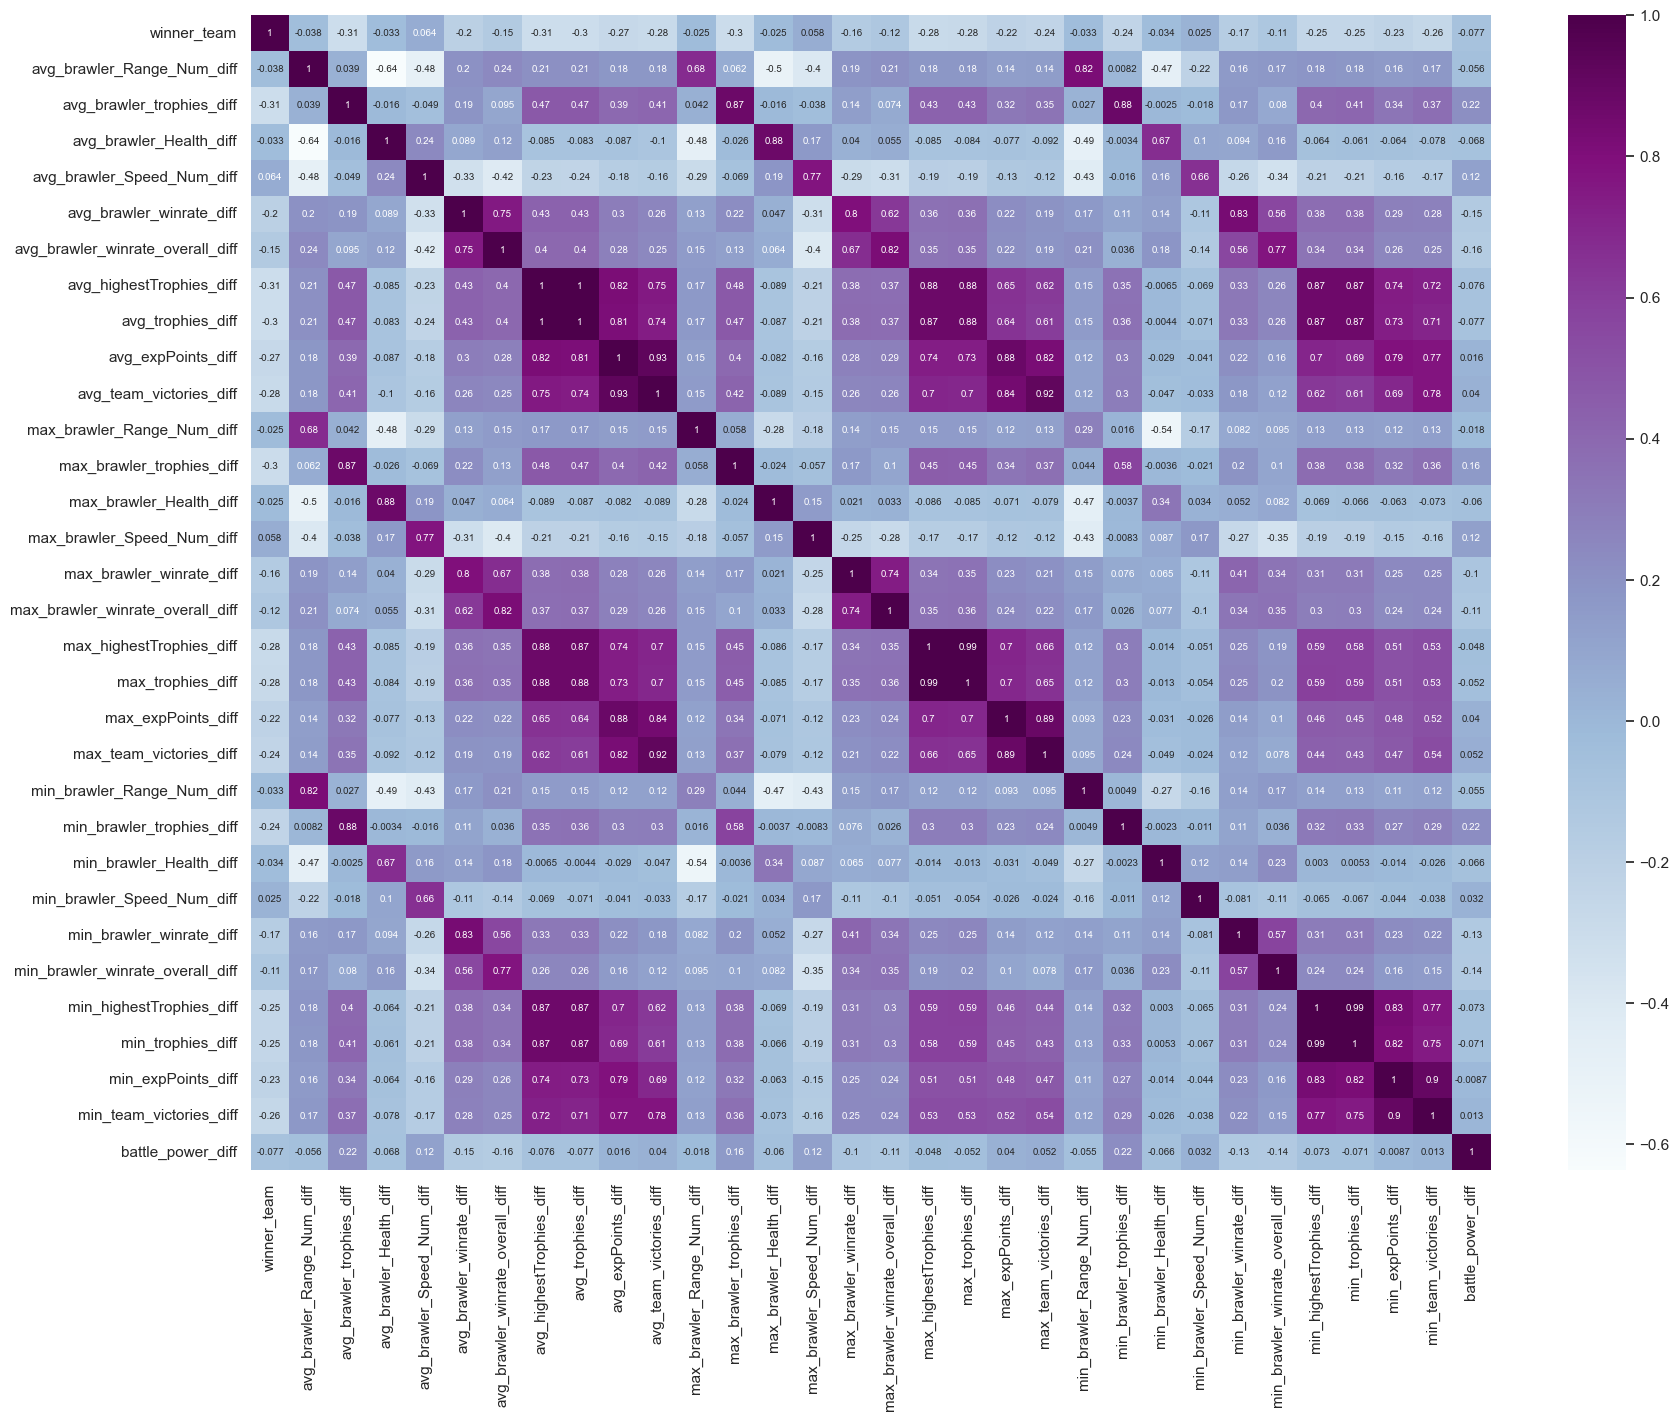

In [218]:
# heatmap de correlaciones

cols=[
    'winner_team',
    'avg_brawler_Range_Num_diff',
	'avg_brawler_trophies_diff',
	'avg_brawler_Health_diff',
	'avg_brawler_Speed_Num_diff',
	'avg_brawler_winrate_diff',
	'avg_brawler_winrate_overall_diff',
	'avg_highestTrophies_diff',
	'avg_trophies_diff',
	'avg_expPoints_diff',
	'avg_team_victories_diff',
	'max_brawler_Range_Num_diff',
	'max_brawler_trophies_diff',
	'max_brawler_Health_diff',
	'max_brawler_Speed_Num_diff',
	'max_brawler_winrate_diff',
	'max_brawler_winrate_overall_diff',
	'max_highestTrophies_diff',
	'max_trophies_diff',
	'max_expPoints_diff',
	'max_team_victories_diff',
	'min_brawler_Range_Num_diff',
	'min_brawler_trophies_diff',
	'min_brawler_Health_diff',
	'min_brawler_Speed_Num_diff',
	'min_brawler_winrate_diff',
	'min_brawler_winrate_overall_diff',
	'min_highestTrophies_diff',
	'min_trophies_diff',
	'min_expPoints_diff',
	'min_team_victories_diff',
	'battle_power_diff',
]

fig, ax = plt.subplots(figsize=(20,15))
sns.heatmap(df[cols].corr(numeric_only=True), annot=True, annot_kws={"size": 7}, cmap='BuPu', ax=ax)
plt.show()

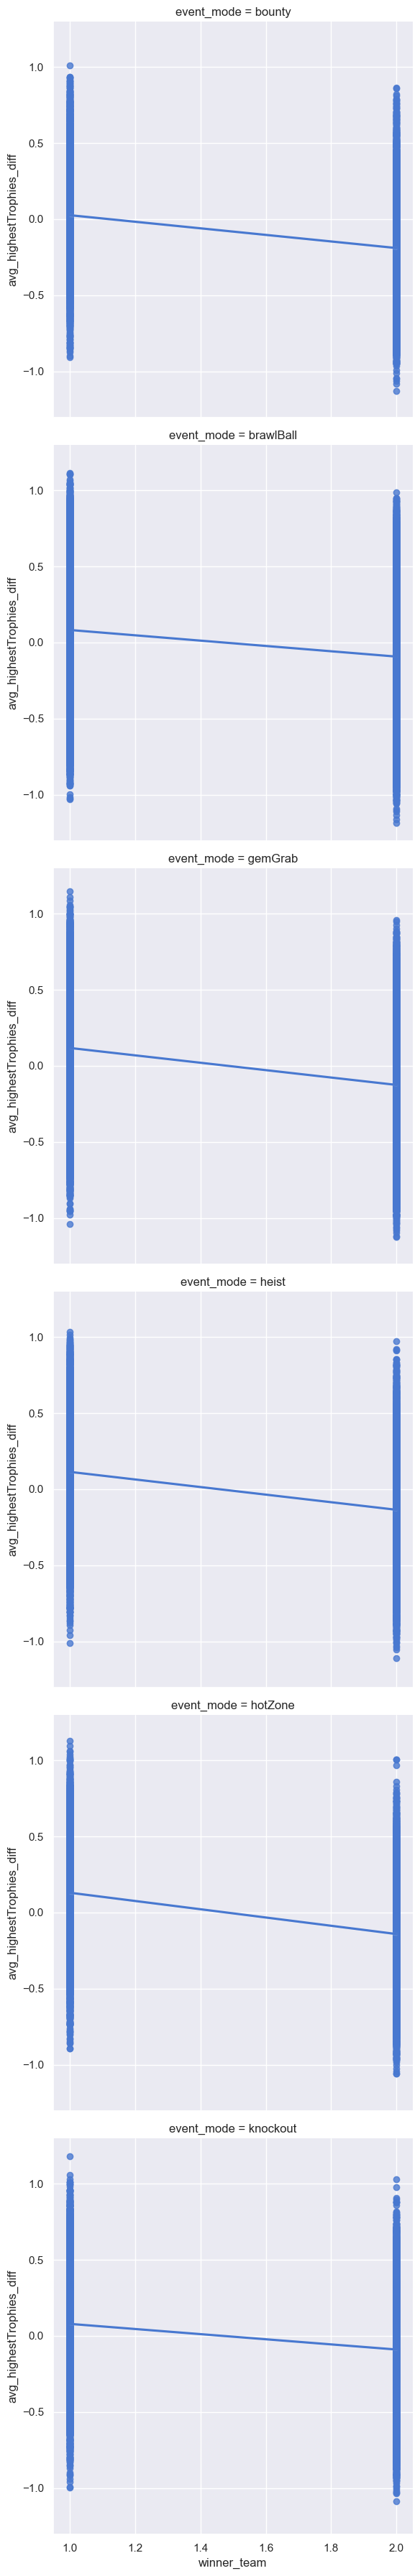

In [224]:
# graficar relacion entre columnas
sns.lmplot(data=df, x='winner_team', y='avg_highestTrophies_diff', row='event_mode', height=6)
sns.despine(left=False, bottom=False)
plt.show()

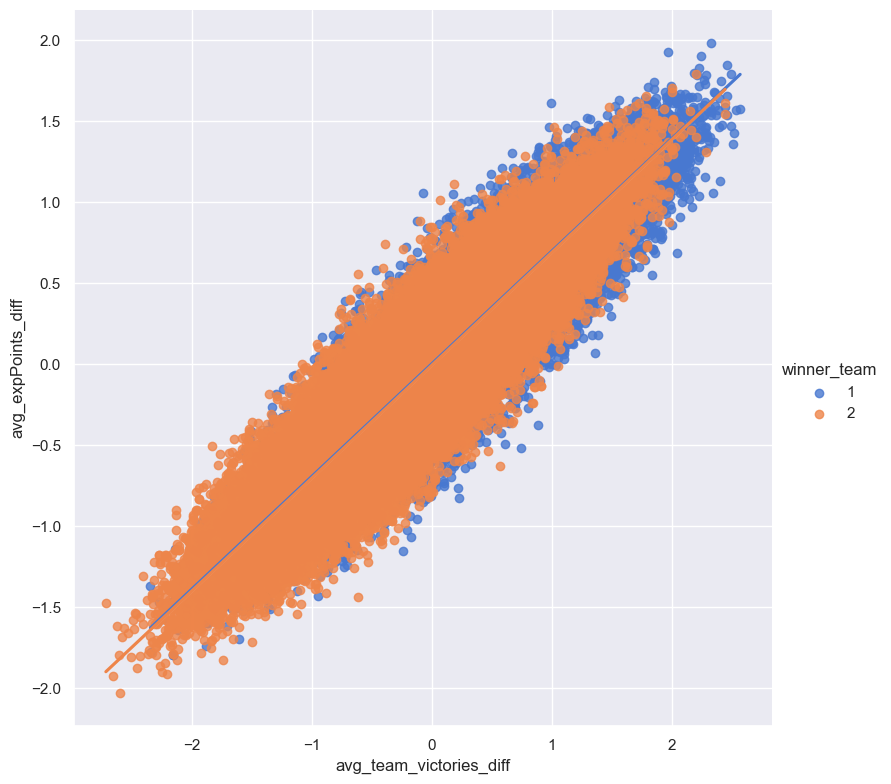

In [226]:
sns.lmplot(data=df, x='avg_team_victories_diff', y='avg_expPoints_diff', hue='winner_team', height=8)
plt.show()